In [1]:
import glob
import re
from astropy.io import fits
from astropy.table import Table
import numpy
import seaborn as sns
import pylab
from matplotlib import colors
import matplotlib
import matplotlib.tri as tri

In [2]:
files = glob.glob("/gpfs/slac/lsst/fs3/g/data/R_and_D/ts8/20210622/*/*S00.fits")

In [3]:
results = []
for afile in files:
    with fits.open(afile) as f:
        ret = re.search("v25_(?P<ISO1>.*)_(?P<ISO2>.*).seq",f[0].header["SEQFILE"]).groupdict()
        ret.update({ "std({:02d})".format(i): f[i].data[10:2000,522:].std() for i in range(1,17) } )
    results.append(ret)


In [4]:
table = Table(results)
table.meta = fits.open(files[0])[0].header

In [5]:
cond=table["std(01)"]<1000
filtered = table[cond].group_by(["ISO1","ISO2"]).groups.aggregate(numpy.mean)
filtered

ISO1,ISO2,std(01),std(02),std(03),std(04),std(05),std(06),std(07),std(08),std(09),std(10),std(11),std(12),std(13),std(14),std(15),std(16)
str3,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
060,325,9.980913598167126,11.752033869338375,13.074179500660977,13.89494667219733,13.512834246486056,12.450879167141908,10.454047711010864,7.119145788784677,9.751499843345115,12.154407239964057,14.845516928007077,16.809801935072073,17.416682653015698,16.892213909977045,15.003188820047518,12.653830324980774
060,385,10.993408748218135,12.439675220746631,13.47037539946317,14.415643585050466,14.069872177830627,13.105834306762404,11.21936300756915,7.396412218528563,9.889677648692963,13.286481684174186,16.064403614466755,18.003097352306646,18.356693197524677,17.950491605869797,16.30171766206432,14.059438173524562
060,400,11.145969599986424,12.510376762786782,13.529152066199687,14.486930992299362,14.151366060716294,13.211696019297372,11.396067031462534,7.230849117015194,9.93984571621719,13.590438209561531,16.095036194174423,18.245120012497967,18.46050500765835,17.859939030823693,16.43643391866419,14.263163601201809
060,415,11.05301484153072,12.408149726198852,13.50625182739551,14.358935874890465,14.030674240564645,13.050418414554107,11.305191276535618,7.238718391334568,9.94084458208375,13.502317056779981,16.114888359832708,17.97004150426813,18.363340415553683,17.630918865450287,16.12177058858562,14.112890981556143
060,445,10.522436183628942,11.533298142929498,12.527669197337326,13.284070241217371,12.980123304833882,12.166015969829514,10.886924658494754,7.264340411678181,10.056642868001358,12.961878772571977,15.070776445966061,16.655764970038586,16.907316285035353,16.345170902377838,15.00255107977072,13.201218888303394
060,460,9.93127362124997,10.90990604278955,11.623973303736472,12.439602842822309,12.146156208840921,11.442304132359729,10.339487705643165,7.249343899562043,10.06125316659565,12.295839234159365,14.16374064681692,15.67323349117207,15.796533242231412,15.223470204417238,14.311675522927478,12.436878439828275
090,325,9.839718218138282,11.584889429935602,12.979966252587623,13.793895010289043,13.526590907868979,12.39886701715927,10.120159299562987,7.223605124935833,9.711277679971596,11.803444402714637,14.564426538049311,16.571416856507643,17.27393013509604,16.702201796624383,14.989365802924482,12.439006299177466
090,370,10.207223940924344,11.66170677575351,12.775858366807135,13.649673607708884,13.433491078051349,12.489783723451076,10.59688809852308,7.07456761321887,9.678305878776236,12.677254689935737,15.251602837683743,17.12545788037384,17.462472040774923,16.834515097683713,15.219805041799404,13.08907925406585
090,460,9.13989362518263,10.221687767791645,10.821462302961669,11.544675989630242,11.321111894266581,10.858984192710276,9.648052893810274,7.165124824012295,9.835038861371109,11.700545441521347,13.709036129942362,14.700733819892731,14.85707607357872,14.45511411952549,13.362722068380036,11.688688349360461


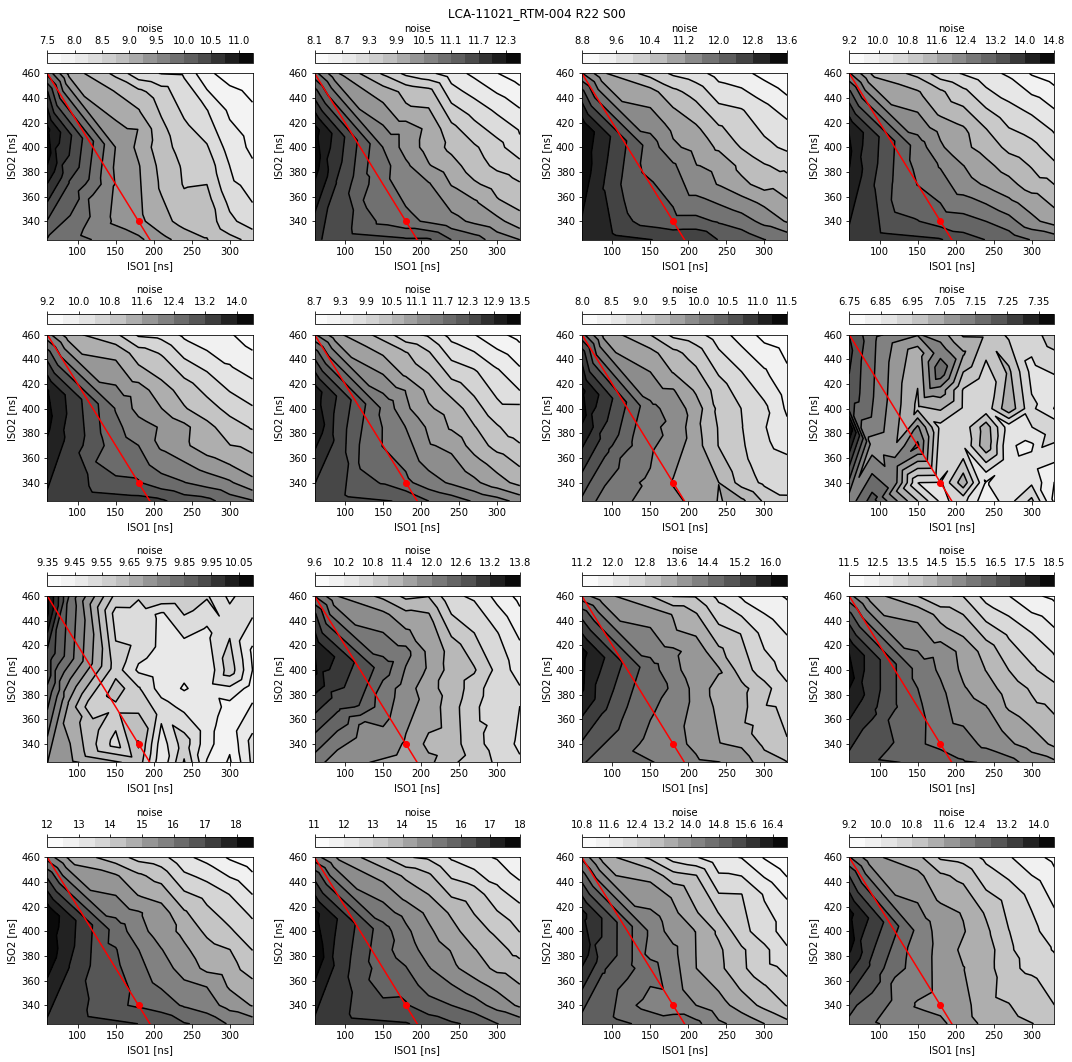

In [6]:

iso1 = filtered["ISO1"].astype(numpy.int32)
iso2 = filtered["ISO2"].astype(numpy.int32)

x = numpy.arange(iso1.min(), iso1.max())

fig, axs = pylab.subplots(4, 4, figsize=(15,15),facecolor='w')
for i, ax in enumerate(axs.flatten()):
    key = "std({:02d})".format(i+1)
    z=filtered[key]
    ax.tricontour(iso1,iso2,z,levels=14,colors="k")
    cntr = ax.tricontourf(iso1,iso2,z,levels=14, cmap="Greys")
    fig.colorbar(cntr, ax=ax,location="top",orientation="horizontal",label="noise")
    ax.set_xlabel("ISO1 [ns]")
    ax.set_ylabel("ISO2 [ns]")
    ax.plot( [180] , [340], "ro" )
    ax.plot( x, -(x-180)+340, "r-" )
    ax.set_xlim( iso1.min(), iso1.max() )
    ax.set_ylim( iso2.min(), iso2.max() )
pylab.suptitle(" ".join([ table.meta[akey] for akey in ["RAFTNAME","RAFTBAY","CCDSLOT"] ]))
pylab.tight_layout()